# 1. Create Spark Session & Import Libraries

In [1]:
# if pyspark needs to be installed:
# !pip install pyspark findspark

In [2]:
# spark libraries
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField

# ds libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ml libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/07 05:16:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2. Define Schema & Data Preprocessing

In [3]:
# define schema
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

# read in csv data file
data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

# edit formatting of flight date
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

### Data Checking

In [4]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [5]:
# df.show(5, truncate=False)
df.limit(5).toPandas()

25/05/07 05:16:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [6]:
# Drop Irrelevant Fields
columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)

# Drop Nulls
df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

# Outlier Handling
df_cleaned = df_cleaned.filter((F.col("CRS_ELAPSED_TIME") > 0) & (F.col("CRS_ELAPSED_TIME") < 1000))
df_cleaned = df_cleaned.filter((F.col("DISTANCE") > 0) & (F.col("DISTANCE") < 3000))

### Data Checking

In [7]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [8]:
# df.show(5, truncate=False)
df.limit(5).toPandas()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


# 3. Feature Engineering

In [9]:
delay_threshold = 60

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))     # dep hour
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))   # dep minute
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))     # arrival hour
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))   # arrival minute
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE") / (F.col("CRS_ELAPSED_TIME") + 1e-6))

featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol])

In [10]:
final_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)



In [11]:
# final_df.show(5, truncate=False)
final_df.limit(5).toPandas()

,AIRLINE_CODE,ORIGIN,DEST,CRS_ELAPSED_TIME,DISTANCE,DEP_HOUR,DEP_MINUTE,ARR_HOUR,ARR_MINUTE,DEP_DAY_OF_WEEK,DEP_MONTH,DEP_DAY_OF_MONTH,DEP_WEEK_OF_YEAR,IS_WEEKEND,DISTANCE_PER_MINUTE,SEVERE_DELAY
0,UA,FLL,EWR,186.0,1065.0,11,55,15,1,4,1,9,2,0,5.725806,0
1,DL,MSP,SEA,235.0,1399.0,21,20,23,15,7,11,19,46,1,5.953191,0
2,UA,DEN,MSP,118.0,680.0,9,54,12,52,6,7,22,29,0,5.762712,0
3,DL,MSP,SFO,260.0,1589.0,16,9,18,29,2,3,6,10,0,6.111538,0
4,NK,MCO,DFW,181.0,985.0,18,40,20,41,1,2,23,8,1,5.441989,0


# 4. Creating Pipeline

In [12]:
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [
    StringIndexer(inputCol = col, outputCol = col+'Index', handleInvalid = "keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol= col+'Index', outputCol = col+'OHE')
    for col in categorical_cols
]

num_vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="NumFeatures"
)

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)

final_vector_assembler = VectorAssembler(
    inputCols=[col+'OHE' for col in categorical_cols] + ["ScaledNumFeatures"], 
    outputCol="features"
)

In [13]:
# Build Preprocessing Pipeline
pipeline = Pipeline(stages = indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])
pipeline_model = pipeline.fit(final_df)
processed_df = pipeline_model.transform(final_df)

25/05/07 05:16:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

### Show Results

In [14]:
processed_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- AIRLINE_CODEIndex: double (nullable = false)
 |-- ORIGINIndex: double (nullable = false)
 |-- DESTIndex: double (nullable = false)
 |-- AIRLINE_CODEOHE: vector (nullable = true)
 |-- ORIGINOHE: vector (nullable = true)
 |-- DESTOHE: vector (nullable = true)
 |-- NumFeatures: vector (nul

In [15]:
#processed_df.select("features", labelCol).show(5, truncate=False)
processed_df.select("features", labelCol).limit(5).toPandas()

,features,SEVERE_DELAY
0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


# 5. Training Models

In [16]:
# Train/Test Split
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)
train_df_sampled = train_df.sample(withReplacement=False, fraction=0.3, seed=101)

label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
label_indexer_model = label_indexer.fit(train_df)

train_df = label_indexer_model.transform(train_df)
test_df = label_indexer_model.transform(test_df)

## Handling Class Imbalance

### Using Class Weights

In [17]:
# Handle Class Imbalance
train_df_weighted = train_df.withColumn(
    "classWeightCol",
    F.when(F.col("indexedLabel") == 0.0, 0.2).otherwise(1.0)
)

### Using Resampling

In [18]:
# # Count each class
# class_counts = train_df.groupBy("indexedLabel").count().toPandas()

# print("Class distribution before resampling:")
# print(class_counts)

# majority_count = class_counts["count"].max()
# minority_label = class_counts.loc[class_counts["count"] != majority_count, "indexedLabel"].values[0]

# # Filter minority and majority
# minority_df = train_df.filter(F.col("indexedLabel") == minority_label)
# majority_df = train_df.filter(F.col("indexedLabel") != minority_label)

# # Oversample minority
# ratio = majority_count / minority_df.count()
# oversampled_minority = minority_df.sample(withReplacement=True, fraction=ratio)

# # Combine back
# balanced_train_df = majority_df.unionAll(oversampled_minority)


### Random Forest Model

In [19]:
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="label", 
    numTrees=30, 
    maxDepth=5, 
    seed=101
    )

# class weights
rf_model = rf.fit(train_df_weighted) 

# resampling 
# rf_model = rf.fit(balanced_train_df) 

### Logistic Regression Model

In [20]:
lr = LogisticRegression(
    featuresCol="features", 
    labelCol="label", 
    maxIter=30, 
    regParam=0.1, 
    elasticNetParam=0.8
)


# class weights
lr_model = lr.fit(train_df_weighted)

# resampling 
# lr_model = lr.fit(balanced_train_df)

25/05/07 05:17:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/07 05:17:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

### GBTClassifier Model

In [21]:
gbt = GBTClassifier(
    featuresCol="features", 
    labelCol="label", 
    weightCol="classWeightCol", # comment out if using resampling
    maxIter=50, 
    maxDepth=5, 
    stepSize=0.1, 
    seed=101)

# class weights
gbt_model = gbt.fit(train_df_weighted)

# resampling 
# gbt_model = gbt.fit(balanced_train_df)

## 6. Evaluate Models


Random Forest Evaluation:
AUC: 0.6341
Accuracy: 0.9401
Precision: 0.8838
Recall: 0.9401
F1 Score: 0.9111


/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

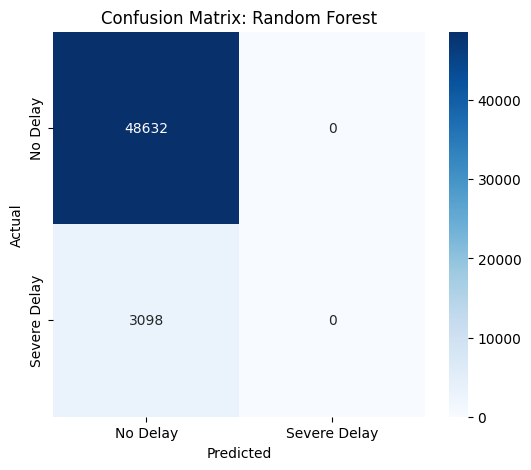

[Stage 581:============================>                            (2 + 2) / 4]


Logistic Regression Evaluation:
AUC: 0.5000
Accuracy: 0.9401
Precision: 0.8838
Recall: 0.9401
F1 Score: 0.9111


/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

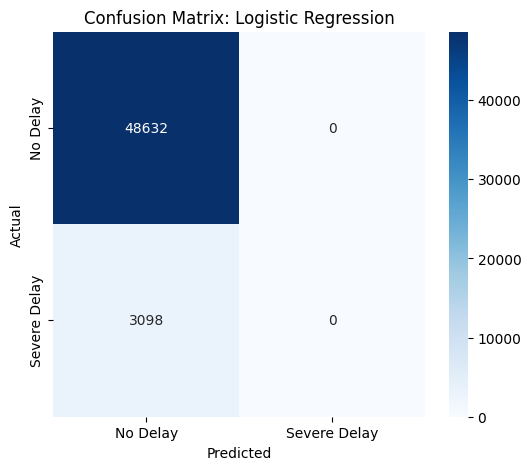

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



GBT Evaluation:
AUC: 0.6670
Accuracy: 0.9280
Precision: 0.8991
Recall: 0.9280
F1 Score: 0.9112


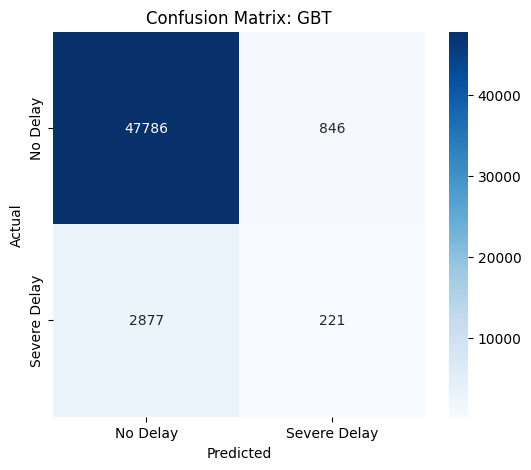

In [22]:
# Evaluate Models
models = {
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "GBT": gbt_model
}

for model_name, model in models.items():
    predictions = model.transform(test_df)
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC"
    )
    auc = evaluator.evaluate(predictions)

    evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

    print(f"\n{model_name} Evaluation:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=["No Delay", "Severe Delay"],
                yticklabels=["No Delay", "Severe Delay"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [23]:
# Save GBT Model and Pipeline
pipeline_path = "./flight_delay_gbt_pipeline_model"
model_path = "./flight_delay_gbt_model"

pipeline_model.write().overwrite().save(pipeline_path)  # This saves the preprocessing pipeline
gbt_model.write().overwrite().save(model_path)          # <-- Save GBT model here!


## 7. Feature Importance - Extract & visualize from flight data GBTClassifier model

- Step 1: Extract feature names based on pipeline
- Step 2: Extract feature importances from the trained GBTClassifier model
- Step 3: Match feature names with importance scores and sort by importance
- Step 4: Create a DataFrame for visualization
- Step 5: Visualize using matplotlib

In [27]:
# STEP 1: Extract feature names based on pipeline
# For categorical columns that were one-hot encoded
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]

# Get the StringIndexer and OneHotEncoder models from pipeline
indexer_models = [stage for stage in pipeline_model.stages if isinstance(stage, StringIndexerModel) and stage.getInputCol() in categorical_cols]
encoder_models = [stage for stage in pipeline_model.stages if isinstance(stage, OneHotEncoderModel) and stage.getInputCol() in [col+"Index" for col in categorical_cols]]

# Extract OHE category sizes
ohe_sizes = []
for model in encoder_models:
    ohe_sizes.append(model.categorySizes)

# Build full list of OHE feature names
ohe_feature_names = []
for col, sizes in zip(categorical_cols, ohe_sizes):
    for i in range(sizes[0]):  # Each categorical column creates sizes[0] one-hot columns
        ohe_feature_names.append(f"{col}_OHE_{i}")

# Get numerical column names
numerical_cols = [col for col in featureCols if col not in categorical_cols]

# Full feature list (in the same order as in the VectorAssembler)
final_feature_names = ohe_feature_names + numerical_cols


# STEP 2: Extract feature importances from the trained GBTClassifier model
importances = gbt_model.featureImportances.toArray().tolist()


# STEP 3: Match feature names with importance scores and sort by importance
feature_importance = sorted(zip(final_feature_names, importances), key=lambda x: x[1], reverse=True)

# Print top features
print("Top 10 Feature Importances:")
for name, score in feature_importance[:10]:
    print(f"{name}: {score:.4f}")


# Step 4: Create a DataFrame for visualization
top_n = 15  # Display top 15 features
top_features = feature_importance[:top_n]
feature_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])


Top 10 Feature Importances:
DEP_DAY_OF_WEEK: 0.1154
DEST_OHE_375: 0.0810
DISTANCE: 0.0727
ARR_MINUTE: 0.0606
DEP_MINUTE: 0.0475
ARR_HOUR: 0.0323
DEP_HOUR: 0.0321
DEST_OHE_373: 0.0308
CRS_ELAPSED_TIME: 0.0274
AIRLINE_CODE_OHE_0: 0.0241


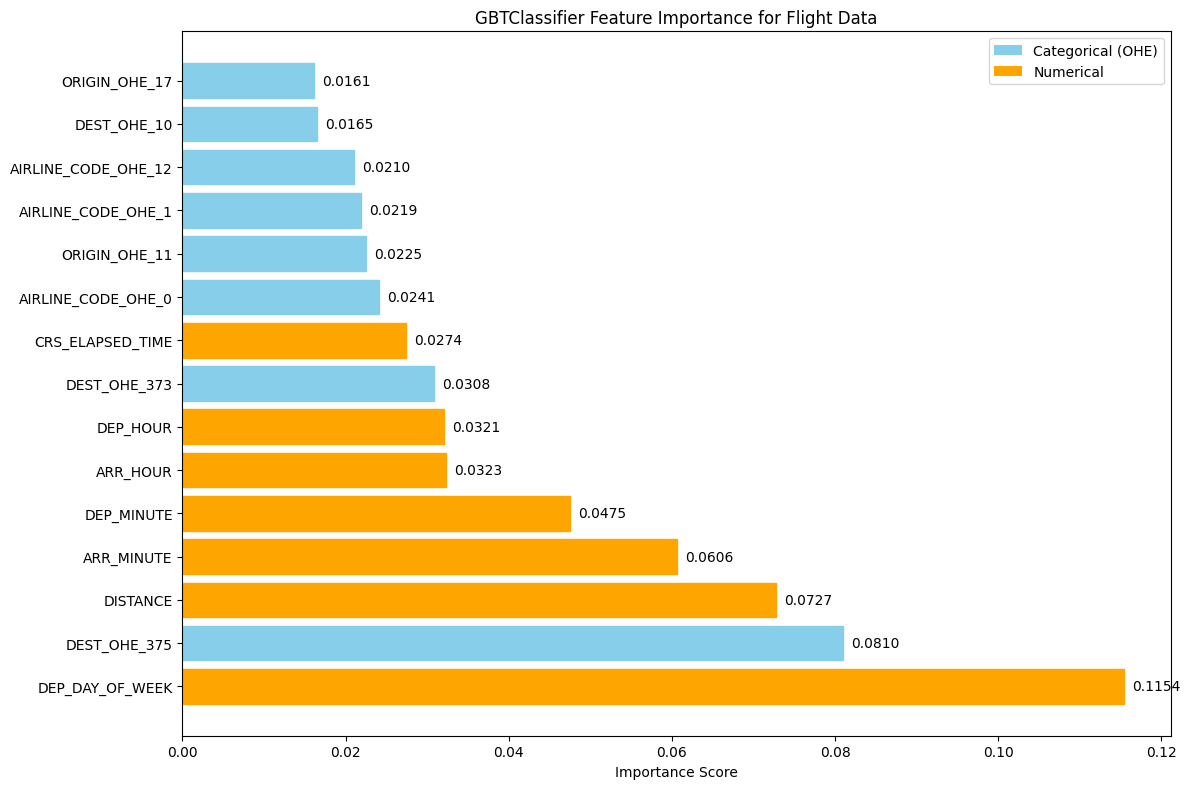

In [34]:
# STEP 5: Visualize Feature Importances
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
bars = plt.barh(y=np.arange(len(feature_df)), width=feature_df['Importance'])

# Color the bars by feature type (categorical vs numerical)
for i, feature in enumerate(feature_df['Feature']):
    if 'OHE' in feature:
        bars[i].set_color('skyblue')
    else:
        bars[i].set_color('orange')

# Set y-ticks to feature names
plt.yticks(np.arange(len(feature_df)), feature_df['Feature'])
plt.xlabel('Importance Score')
plt.title('GBTClassifier Feature Importance for Flight Data')
plt.tight_layout()

# Add values on bars
for i, v in enumerate(feature_df['Importance']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='Categorical (OHE)'),
    Patch(facecolor='orange', label='Numerical')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


In [36]:
# Additional Analysis: Group importances by original feature
# This helps understand the total importance of each original categorical feature
feature_groups = {}

# Group OHE features by their original categorical column
for feature, importance in feature_importance:
    if 'OHE' in feature:
        # Extract original column name (before one-hot encoding)
        original_feature = feature.split('_OHE_')[0]
        if original_feature not in feature_groups:
            feature_groups[original_feature] = 0
        feature_groups[original_feature] += importance
    else:
        # Numerical features stay as they are
        feature_groups[feature] = importance

# Sort by total importance
grouped_importance = sorted(feature_groups.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importance by Original Column:")
for name, score in grouped_importance:
    print(f"{name}: {score:.4f}")



Feature Importance by Original Column:
DEST: 0.2471
AIRLINE_CODE: 0.1783
ORIGIN: 0.1666
DEP_DAY_OF_WEEK: 0.1154
DISTANCE: 0.0727
ARR_MINUTE: 0.0606
DEP_MINUTE: 0.0475
ARR_HOUR: 0.0323
DEP_HOUR: 0.0321
CRS_ELAPSED_TIME: 0.0274
DEP_DAY_OF_MONTH: 0.0155
DEP_MONTH: 0.0046


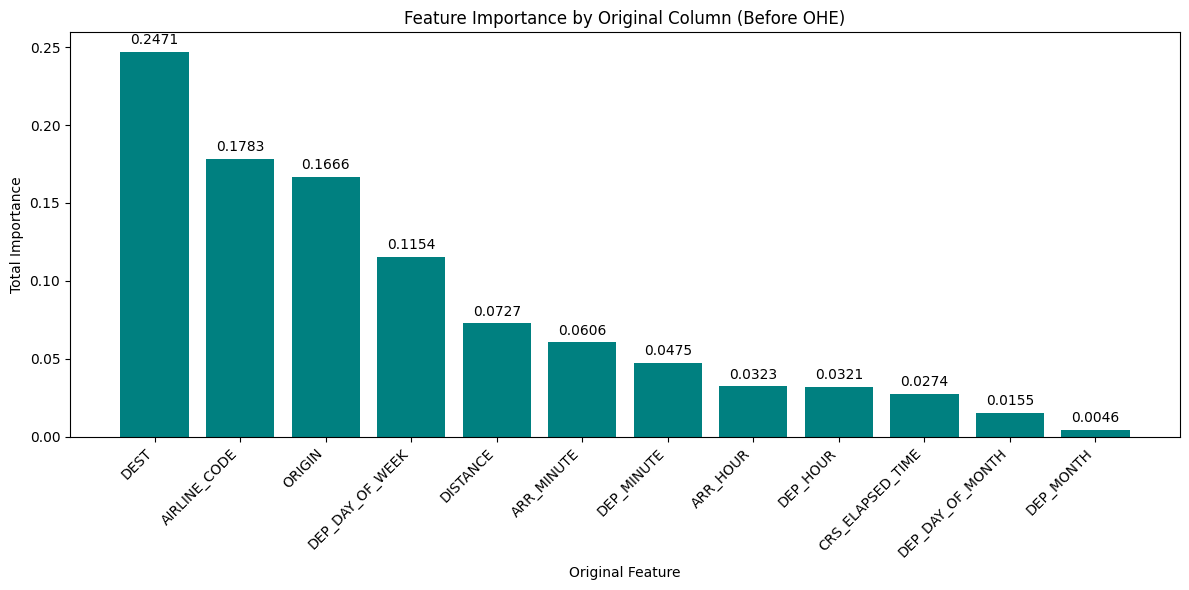

In [38]:
# Visualize grouped importance
plt.figure(figsize=(12, 6))
group_df = pd.DataFrame(grouped_importance, columns=['Original Feature', 'Total Importance'])

# Create bar chart for grouped features
plt.bar(group_df['Original Feature'], group_df['Total Importance'], color='teal')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Original Feature')
plt.ylabel('Total Importance')
plt.title('Feature Importance by Original Column (Before OHE)')

# Add values on bars
for i, v in enumerate(group_df['Total Importance']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

In [25]:
spark.stop()
print("\nSpark Session Stopped.")